In [ ]:
#Importing of packages
from sklearn.linear_model import LinearRegression,LogisticRegression,Ridge
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import ensemble
from sklearn.metrics import roc_auc_score,accuracy_score,classification_report,plot_confusion_matrix,roc_curve,recall_score,confusion_matrix
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import label_binarize
import tensorflow as tf
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from itertools import combinations,product

In [ ]:
#from google.colab import drive 
#drive.mount('/gdrive')

### Load Data and Train-Test Split

In [ ]:
#data=pd.read_csv('/gdrive/My Drive/data_final.csv',index_col=0).reset_index(drop=True)
data=pd.read_csv('data_final.csv',index_col=0).reset_index(drop=True)

In [ ]:
data=data.loc[data['ESG Risk Rating']!='Negligible ESG Risk']
data.head()

,Companies,ESG Risk Score,ESG Risk Rating,Opportunities in Clean Tech Sentiment Score,Carbon Emissions Sentiment Score,Water Stress Sentiment Score,Electronic Waste Sentiment Score,Toxic Emissions & Waste Sentiment Score,Human Capital Development Sentiment Score,Privacy and Data Security Sentiment Score,Labor Management Sentiment Score,Governance Sentiment Score,Ticker,Market Capitalisation,Page Count,Sentence Count,Word Count
0,24SevenOffice Group,24.6,Medium ESG Risk,0.357958,0.000000,0.000000,0.000000,0.0,0.471713,0.375589,0.218405,0.330786,719.F,0.000041,0.123596,0.055704,0.055670
1,"2U, Inc",19.8,Low ESG Risk,0.226180,-0.077200,-0.077200,-0.077200,0.0,0.563257,0.406256,0.275578,0.390339,TWOU,0.000428,0.106742,0.034621,0.035246
2,Absolute Software Corp,24.1,Medium ESG Risk,-0.279050,-0.229400,-0.421500,-0.421500,0.0,0.000000,0.231411,0.827100,0.488943,ABST,0.000185,0.005618,0.004217,0.003077
4,"ACI Worldwide, Inc",20.8,Medium ESG Risk,0.399900,0.353917,0.470240,0.177225,0.0,0.678200,0.290737,0.232244,0.263880,ACIW,0.001358,0.109551,0.033289,0.031902
5,"Activision Blizzard, Inc",19.2,Low ESG Risk,0.571565,0.426843,0.262167,0.195600,0.0,0.623671,0.317916,0.288306,0.413094,ATVI,0.027623,0.106742,0.072348,0.075400


In [ ]:
#Split into 60% training,20% validation, 20% test
x_train,x_test,y_train,y_test=train_test_split(data.drop(columns=['ESG Risk Rating']),data['ESG Risk Rating'],test_size=0.4,random_state=123,stratify=data['ESG Risk Rating'].tolist())
x_test,x_validation,y_test,y_validation=train_test_split(x_test,y_test,test_size=0.5,random_state=123,stratify=y_test)

In [ ]:
#Remove the features company name and ESG Risk Score
x_train=x_train[list(filter(lambda x:x!='Ticker',x_train.columns.tolist()[2:]))]
x_test=x_test[list(filter(lambda x:x!='Ticker',x_test.columns.tolist()[2:]))]
x_validation=x_validation[list(filter(lambda x:x!='Ticker',x_validation.columns.tolist()[2:]))]

In [ ]:
y_train.value_counts()

Medium ESG Risk    135
Low ESG Risk        99
High ESG Risk        6
Name: ESG Risk Rating, dtype: int64

### Model 1: Decision Tree

In [ ]:
#Test all possible combinations of features to determine the one that performs best on validation data
accuracy_scores=[]
roc_scores_tree=[]
for i in range(2,len(x_train.columns.tolist())):
  for combi in list(combinations(x_train.columns.tolist(),i)):
     for num in list(product(['gini','entropy'],range(1,10))):
        decision_tree=DecisionTreeClassifier(criterion=num[0],max_depth=num[1], random_state=123)
        decision_tree.fit(x_train[list(combi)],y_train)
        acc=accuracy_score(y_validation,decision_tree.predict(x_validation[list(combi)]))
        roc=roc_auc_score(y_validation,decision_tree.predict_proba(x_validation[list(combi)]),multi_class='ovr',average="macro")
        accuracy_scores.append(((num[0],num[1]),combi,acc))
        roc_scores_tree.append(((num[0],num[1]),combi,roc))

In [ ]:
#Creating a Dataframe with ROC scores for each combination of features
decisionTrees = pd.DataFrame(roc_scores_tree)
decisionTrees.columns = ['Hyperparameters', 'Features', 'ROC']

#Combining the Dataframe with accuracy scores for each combination of features
decisionTreeAccuracy=pd.DataFrame(accuracy_scores)
decisionTrees['Accuracy'] = decisionTreeAccuracy[2]
decisionTrees['Average'] = (decisionTrees['Accuracy']+decisionTrees['ROC'])/2
decisionTrees['Number of features']=decisionTrees['Features'].apply(lambda x:len(x))

decisionTrees = decisionTrees.sort_values('Average', ascending=False)
decisionTrees.head()

,Hyperparameters,Features,ROC,Accuracy,Average,Number of features
48139,"(gini, 8)","(Opportunities in Clean Tech Sentiment Score, ...",0.829875,0.753086,0.791481,6
54610,"(entropy, 8)","(Opportunities in Clean Tech Sentiment Score, ...",0.826681,0.740741,0.783711,6
27105,"(entropy, 7)","(Opportunities in Clean Tech Sentiment Score, ...",0.824603,0.728395,0.776499,5
51082,"(entropy, 8)","(Opportunities in Clean Tech Sentiment Score, ...",0.818264,0.728395,0.773329,6
51081,"(entropy, 7)","(Opportunities in Clean Tech Sentiment Score, ...",0.824396,0.716049,0.770223,6


In [ ]:
decisionTrees.iloc[0][1]

('Opportunities in Clean Tech Sentiment Score',
 'Carbon Emissions Sentiment Score',
 'Privacy and Data Security Sentiment Score',
 'Governance Sentiment Score',
 'Page Count',
 'Sentence Count')

                 precision    recall  f1-score   support

  High ESG Risk       0.50      1.00      0.67         1
   Low ESG Risk       0.73      0.65      0.69        34
Medium ESG Risk       0.78      0.83      0.80        46

       accuracy                           0.75        81
      macro avg       0.67      0.82      0.72        81
   weighted avg       0.75      0.75      0.75        81

validation data accuracy score is 0.7530864197530864


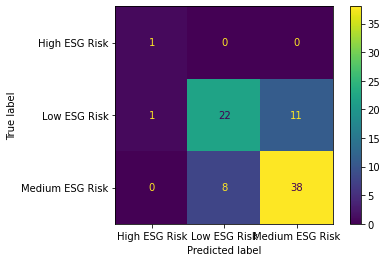

In [ ]:
decision_tree=DecisionTreeClassifier(criterion=decisionTrees.iloc[0][0][0],max_depth=decisionTrees.iloc[0][0][1], random_state=123)
decision_tree.fit(x_train[list(decisionTrees.iloc[0][1])],y_train)
plot_confusion_matrix(decision_tree,x_validation[list(decisionTrees.iloc[0][1])],y_validation)
print(classification_report(y_validation,decision_tree.predict(x_validation[list(decisionTrees.iloc[0][1])])))

print('validation data accuracy score is {}'.format(accuracy_score(y_validation,decision_tree.predict(x_validation[list(decisionTrees.iloc[0][1])]))))


In [ ]:
print('train data accuracy score is {}'.format(accuracy_score(y_train,decision_tree.predict(x_train[list(decisionTrees.iloc[0][1])]))))
print('test data accuracy score is {}'.format(accuracy_score(y_test,decision_tree.predict(x_test[list(decisionTrees.iloc[0][1])]))))

train data accuracy score is 0.9041666666666667
test data accuracy score is 0.525


In [ ]:
roc_auc_score(y_validation,decision_tree.predict_proba(x_validation[list(decisionTrees.iloc[0][1])]),multi_class='ovr',average="macro")

0.8298749795940578

In [ ]:
decisionTrees.to_excel('decision_tree_updated.xlsx')

### Model 2: Random Forest

In [ ]:
accuracy_scores_random_forest=[]
roc_scores_random_forest=[]
for i in range(2,len(x_train.columns.tolist())):
  for combi in list(combinations(x_train.columns.tolist(),i)):
        rf_classifier=ensemble.RandomForestClassifier(random_state=123)
        rf_classifier.fit(x_train[list(combi)],y_train)
        acc=accuracy_score(y_validation,rf_classifier.predict(x_validation[list(combi)]))
        roc=roc_auc_score(y_validation,rf_classifier.predict_proba(x_validation[list(combi)]),multi_class='ovr',average="macro")
        accuracy_scores_random_forest.append((combi,acc))
        roc_scores_random_forest.append((combi,roc))

In [ ]:
#Creating a Dataframe with ROC scores for each combination of features
randomForest = pd.DataFrame(roc_scores_random_forest)
randomForest.columns = ['Features', 'ROC']

#List Of accuracy scores for each combination of features
randomForestAccuracy=pd.DataFrame(accuracy_scores_random_forest)
randomForest['Accuracy'] = randomForestAccuracy[1]
randomForest['Average'] = (randomForest['Accuracy']+randomForest['ROC'])/2
randomForest['Number of features']=randomForest['Features'].apply(lambda x:len(x))

randomForest = randomForest.sort_values('Average', ascending=False)
randomForest.head()

,Features,ROC,Accuracy,Average,Number of features
5831,"(Opportunities in Clean Tech Sentiment Score, ...",0.821619,0.728395,0.775007,8
5040,"(Carbon Emissions Sentiment Score, Water Stres...",0.815246,0.728395,0.771820,7
7624,"(Carbon Emissions Sentiment Score, Water Stres...",0.827103,0.716049,0.771576,9
6604,"(Carbon Emissions Sentiment Score, Water Stres...",0.800828,0.740741,0.770784,8
1812,"(Carbon Emissions Sentiment Score, Toxic Emiss...",0.812682,0.728395,0.770539,5


                 precision    recall  f1-score   support

  High ESG Risk       0.00      0.00      0.00         1
   Low ESG Risk       0.73      0.56      0.63        34
Medium ESG Risk       0.73      0.87      0.79        46

       accuracy                           0.73        81
      macro avg       0.49      0.48      0.48        81
   weighted avg       0.72      0.73      0.72        81

validation data accuracy score is 0.7283950617283951


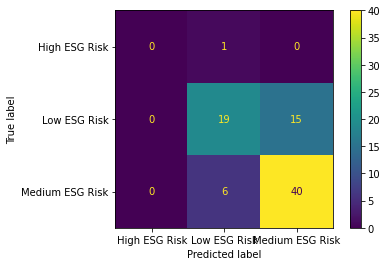

In [ ]:
random_forest=ensemble.RandomForestClassifier(random_state=123)
random_forest.fit(x_train[list(randomForest.iloc[0][0])],y_train)
plot_confusion_matrix(random_forest,x_validation[list(randomForest.iloc[0][0])],y_validation)
print(classification_report(y_validation,random_forest.predict(x_validation[list(randomForest.iloc[0][0])])))

print('validation data accuracy score is {}'.format(accuracy_score(y_validation,random_forest.predict(x_validation[list(randomForest.iloc[0][0])]))))

In [ ]:
print('Training data accuracy score is {}'.format(accuracy_score(y_train,random_forest.predict(x_train[list(randomForest.iloc[0][0])]))))
print('Test data accuracy score is {}'.format(accuracy_score(y_test,random_forest.predict(x_test[list(randomForest.iloc[0][0])]))))

Training data accuracy score is 1.0
Test data accuracy score is 0.6125


In [ ]:
roc_auc_score(y_validation,random_forest.predict_proba(x_validation[list(randomForest.iloc[0][0])]),multi_class='ovr',average="macro")

0.8216192860122772

In [ ]:
randomForest.to_excel('random_forest_updated.xlsx')

### Model 3: Extra Trees

In [ ]:
accuracy_scores_extra_tree=[]
roc_scores_extra_tree=[]
for i in range(2,len(x_train.columns.tolist())):
  for combi in list(combinations(x_train.columns.tolist(),i)):
        et_classifier=ensemble.ExtraTreesClassifier(random_state=123)
        et_classifier.fit(x_train[list(combi)],y_train)
        acc=accuracy_score(y_validation,et_classifier.predict(x_validation[list(combi)]))
        roc=roc_auc_score(y_validation,et_classifier.predict_proba(x_validation[list(combi)]),multi_class='ovr',average="macro")
        accuracy_scores_extra_tree.append((combi,acc))
        roc_scores_extra_tree.append((combi,roc))

In [ ]:
#Creating a Dataframe with ROC scores for each combination of features
extraTree = pd.DataFrame(roc_scores_extra_tree)
extraTree.columns = ['Features', 'ROC']

#List Of accuracy scores for each combination of features
extraTreeAccuracy=pd.DataFrame(accuracy_scores_extra_tree)
extraTree['Accuracy'] = extraTreeAccuracy[1]
extraTree['Average'] = (extraTree['Accuracy']+extraTree['ROC'])/2
extraTree['Number of features']=extraTree['Features'].apply(lambda x:len(x))

extraTree = extraTree.sort_values('Average', ascending=False)
extraTree.head()

,Features,ROC,Accuracy,Average,Number of features
5923,"(Opportunities in Clean Tech Sentiment Score, ...",0.816176,0.765432,0.790804,8
7204,"(Opportunities in Clean Tech Sentiment Score, ...",0.838640,0.740741,0.789690,9
5829,"(Opportunities in Clean Tech Sentiment Score, ...",0.821188,0.753086,0.787137,8
6061,"(Opportunities in Clean Tech Sentiment Score, ...",0.841736,0.728395,0.785065,8
5741,"(Electronic Waste Sentiment Score, Human Capit...",0.827306,0.740741,0.784023,7


                 precision    recall  f1-score   support

  High ESG Risk       0.00      0.00      0.00         1
   Low ESG Risk       0.79      0.65      0.71        34
Medium ESG Risk       0.75      0.87      0.81        46

       accuracy                           0.77        81
      macro avg       0.51      0.51      0.51        81
   weighted avg       0.76      0.77      0.76        81

validation data accuracy score is 0.7654320987654321


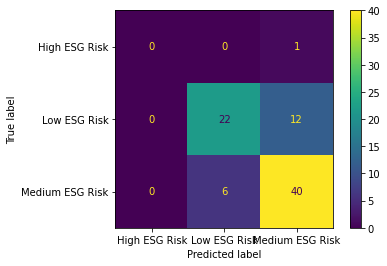

In [ ]:
extra_tree=ensemble.ExtraTreesClassifier(random_state=123)
extra_tree.fit(x_train[list(extraTree.iloc[0][0])],y_train)
plot_confusion_matrix(extra_tree,x_validation[list(extraTree.iloc[0][0])],y_validation)
print(classification_report(y_validation,extra_tree.predict(x_validation[list(extraTree.iloc[0][0])])))

print('validation data accuracy score is {}'.format(accuracy_score(y_validation,extra_tree.predict(x_validation[list(extraTree.iloc[0][0])]))))


In [ ]:
print('train data accuracy score is {}'.format(accuracy_score(y_train,extra_tree.predict(x_train[list(extraTree.iloc[0][0])]))))
print('test data accuracy score is {}'.format(accuracy_score(y_test,extra_tree.predict(x_test[list(extraTree.iloc[0][0])]))))

train data accuracy score is 1.0
test data accuracy score is 0.6875


In [ ]:
roc_auc_score(y_validation,extra_tree.predict_proba(x_validation[list(extraTree.iloc[0][0])]),multi_class='ovr',average="macro")

0.8161756284382394

In [ ]:
extraTree.to_excel('extra_tree_updated.xlsx')

### 4. Logistics Regression

In [ ]:
#from google.colab import files
#gradientBoost.to_csv('gradientBoost.csv')
#files.download('gradientBoost.csv')


In [ ]:
accuracy_scores_logistic=[]
roc_scores_logit=[]
for i in range(2,len(x_train.columns.tolist())):
  for combi in list(combinations(x_train.columns.tolist(),i)):
        logit_classifier=LogisticRegression(random_state=123)
        logit_classifier.fit(x_train[list(combi)],y_train)
        acc=accuracy_score(y_validation,logit_classifier.predict(x_validation[list(combi)]))
        roc=roc_auc_score(y_validation,logit_classifier.predict_proba(x_validation[list(combi)]),multi_class='ovr',average="macro")
        accuracy_scores_logistic.append((combi,acc))
        roc_scores_logit.append((combi,roc))

In [ ]:
#Creating a Dataframe with ROC scores for each combination of features
logisticRegression = pd.DataFrame(roc_scores_logit)
logisticRegression.columns = ['Features', 'ROC']

#List Of accuracy scores for each combination of features
logisticRegressionAccuracy=pd.DataFrame(accuracy_scores_logistic)
logisticRegression['Accuracy'] = logisticRegressionAccuracy[1]
logisticRegression['Average'] = (logisticRegression['Accuracy']+logisticRegression['ROC'])/2
logisticRegression['Number of features']=logisticRegression['Features'].apply(lambda x:len(x))

logisticRegression = logisticRegression.sort_values('Average', ascending=False)
logisticRegression.head()

,Features,ROC,Accuracy,Average,Number of features
4344,"(Opportunities in Clean Tech Sentiment Score, ...",0.654315,0.604938,0.629627,7
6115,"(Opportunities in Clean Tech Sentiment Score, ...",0.652443,0.604938,0.628690,8
2566,"(Opportunities in Clean Tech Sentiment Score, ...",0.647458,0.604938,0.626198,6
7350,"(Opportunities in Clean Tech Sentiment Score, ...",0.647445,0.604938,0.626191,9
174,"(Carbon Emissions Sentiment Score, Human Capit...",0.684399,0.567901,0.626150,3


                 precision    recall  f1-score   support

  High ESG Risk       0.00      0.00      0.00         1
   Low ESG Risk       0.56      0.26      0.36        34
Medium ESG Risk       0.62      0.87      0.72        46

       accuracy                           0.60        81
      macro avg       0.39      0.38      0.36        81
   weighted avg       0.59      0.60      0.56        81

validation data accuracy score is 0.6049382716049383


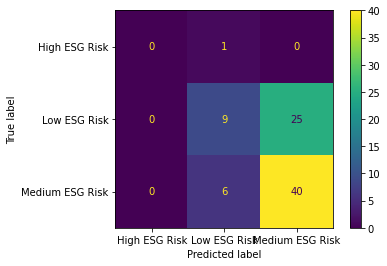

In [ ]:
logit=LogisticRegression(random_state=123)
logit.fit(x_train[list(logisticRegression.iloc[0][0])],y_train)
plot_confusion_matrix(logit,x_validation[list(logisticRegression.iloc[0][0])],y_validation)
print(classification_report(y_validation,logit.predict(x_validation[list(logisticRegression.iloc[0][0])])))

print('validation data accuracy score is {}'.format(accuracy_score(y_validation,logit.predict(x_validation[list(logisticRegression.iloc[0][0])]))))


In [ ]:
print('train data accuracy score is {}'.format(accuracy_score(y_train,logit.predict(x_train[list(logisticRegression.iloc[0][0])]))))
print('test data accuracy score is {}'.format(accuracy_score(y_test,logit.predict(x_test[list(logisticRegression.iloc[0][0])]))))

train data accuracy score is 0.5875
test data accuracy score is 0.5375


In [ ]:
roc_auc_score(y_validation,logit.predict_proba(x_validation[list(logisticRegression.iloc[0][0])]),multi_class='ovr',average="macro")

0.6543152737505733

In [ ]:
logisticRegression.to_excel('logit_updated.xlsx')

### 5. SVC

In [ ]:
accuracy_scores_svm=[]
roc_scores_svm=[]
for i in range(2,len(x_train.columns.tolist())):
  for combi in list(combinations(x_train.columns.tolist(),i)):
      for kernels in ['rbf','poly']:
        svm_classifier=SVC(kernel=kernels,probability=True, random_state=123)
        svm_classifier.fit(x_train[list(combi)],y_train)
        acc=accuracy_score(y_validation,svm_classifier.predict(x_validation[list(combi)]))
        roc=roc_auc_score(y_validation,svm_classifier.predict_proba(x_validation[list(combi)]),multi_class='ovr',average="macro")
        accuracy_scores_svm.append((kernels,combi,acc))
        roc_scores_svm.append((kernels,combi,roc))

In [ ]:
#Creating a Dataframe with ROC scores for each combination of features
SVM_scores = pd.DataFrame(roc_scores_svm)
SVM_scores.columns = ['Hyperparameters', 'Features', 'ROC']

#List Of accuracy scores for each combination of features
SVMaccuracy=pd.DataFrame(accuracy_scores_svm)
SVM_scores['Accuracy'] = SVMaccuracy[2]
SVM_scores['Average'] = (SVM_scores['Accuracy']+SVM_scores['ROC'])/2
SVM_scores['Number of features']=SVM_scores['Features'].apply(lambda x:len(x))

SVM_scores = SVM_scores.sort_values('Average', ascending=False)
SVM_scores.head()

,Hyperparameters,Features,ROC,Accuracy,Average,Number of features
1394,rbf,"(Carbon Emissions Sentiment Score, Human Capit...",0.769496,0.654321,0.711909,4
352,rbf,"(Carbon Emissions Sentiment Score, Human Capit...",0.756597,0.629630,0.693113,3
1396,rbf,"(Carbon Emissions Sentiment Score, Human Capit...",0.780722,0.604938,0.692830,4
354,rbf,"(Carbon Emissions Sentiment Score, Human Capit...",0.760555,0.617284,0.688919,3
396,rbf,"(Carbon Emissions Sentiment Score, Sentence Co...",0.734553,0.641975,0.688264,3


                 precision    recall  f1-score   support

  High ESG Risk       0.00      0.00      0.00         1
   Low ESG Risk       0.60      0.53      0.56        34
Medium ESG Risk       0.69      0.76      0.72        46

       accuracy                           0.65        81
      macro avg       0.43      0.43      0.43        81
   weighted avg       0.64      0.65      0.65        81

validation data accuracy score is 0.654320987654321


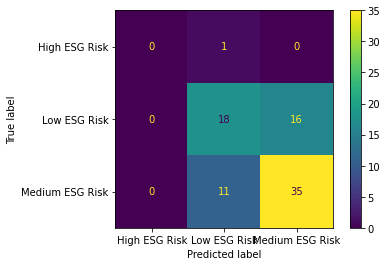

In [ ]:
svm=SVC(kernel=SVM_scores.iloc[0][0],probability=True, random_state=123)
svm.fit(x_train[list(SVM_scores.iloc[0][1])],y_train)
plot_confusion_matrix(svm,x_validation[list(SVM_scores.iloc[0][1])],y_validation)
print(classification_report(y_validation,svm.predict(x_validation[list(SVM_scores.iloc[0][1])])))

print('validation data accuracy score is {}'.format(accuracy_score(y_validation,svm.predict(x_validation[list(SVM_scores.iloc[0][1])]))))


In [ ]:
print('validation data accuracy score is {}'.format(accuracy_score(y_validation,svm.predict(x_validation[list(SVM_scores.iloc[0][1])]))))

validation data accuracy score is 0.654320987654321


In [ ]:
roc_auc_score(y_validation,svm.predict_proba(x_validation[list(SVM_scores.iloc[0][1])]),multi_class='ovr',average="macro")

0.7694962906531716

In [ ]:
SVM_scores.to_excel('svm_updated.xlsx')

### 6. Gradient Boosting

In [ ]:
accuracy_scores_gb=[]
roc_scores_gb=[]
for i in range(2,len(x_train.columns.tolist())):
  for combi in list(combinations(x_train.columns.tolist(),i)):
        gb_classifier=ensemble.GradientBoostingClassifier(random_state=123)
        gb_classifier.fit(x_train[list(combi)],y_train)
        acc=accuracy_score(y_validation,gb_classifier.predict(x_validation[list(combi)]))
        roc=roc_auc_score(y_validation,gb_classifier.predict_proba(x_validation[list(combi)]),multi_class='ovr',average="macro")
        accuracy_scores_gb.append((combi,acc))
        roc_scores_gb.append((combi,roc))

In [ ]:
#Creating a Dataframe with ROC scores for each combination of features
gradientBoost = pd.DataFrame(roc_scores_gb)
gradientBoost.columns = ['Features', 'ROC']

#List Of accuracy scores for each combination of features
gradientBoostAccuracy=pd.DataFrame(accuracy_scores_gb)
gradientBoost['Accuracy'] = gradientBoostAccuracy[1]
gradientBoost['Average'] = (gradientBoost['Accuracy']+gradientBoost['ROC'])/2
gradientBoost['Number of features']=gradientBoost['Features'].apply(lambda x:len(x))

gradientBoost = gradientBoost.sort_values('Average', ascending=False)
gradientBoost.head()

,Features,ROC,Accuracy,Average,Number of features
2518,"(Opportunities in Clean Tech Sentiment Score, ...",0.814217,0.740741,0.777479,6
6063,"(Opportunities in Clean Tech Sentiment Score, ...",0.835640,0.716049,0.775844,8
2519,"(Opportunities in Clean Tech Sentiment Score, ...",0.823153,0.728395,0.775774,6
4361,"(Opportunities in Clean Tech Sentiment Score, ...",0.833742,0.716049,0.774896,7
637,"(Carbon Emissions Sentiment Score, Electronic ...",0.825636,0.716049,0.770843,4


                 precision    recall  f1-score   support

  High ESG Risk       1.00      1.00      1.00         1
   Low ESG Risk       0.74      0.59      0.66        34
Medium ESG Risk       0.74      0.85      0.79        46

       accuracy                           0.74        81
      macro avg       0.83      0.81      0.81        81
   weighted avg       0.74      0.74      0.74        81

validation data accuracy score is 0.7407407407407407


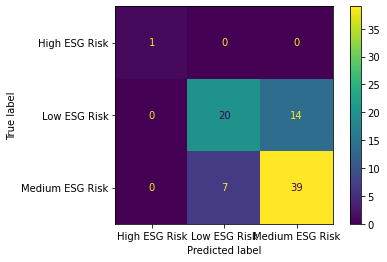

In [ ]:
gradient_boost=ensemble.GradientBoostingClassifier(random_state=123)
gradient_boost.fit(x_train[list(gradientBoost.iloc[0][0])],y_train)
plot_confusion_matrix(gradient_boost,x_validation[list(gradientBoost.iloc[0][0])],y_validation)
print(classification_report(y_validation,gradient_boost.predict(x_validation[list(gradientBoost.iloc[0][0])])))

print('validation data accuracy score is {}'.format(accuracy_score(y_validation,gradient_boost.predict(x_validation[list(gradientBoost.iloc[0][0])]))))


In [ ]:
roc_auc_score(y_validation,gradient_boost.predict_proba(x_validation[list(gradientBoost.iloc[0][0])]),multi_class='ovr',average="macro")

0.8142165284245059

In [ ]:
gradientBoost.to_excel('gb_updated.xlsx')

### 7. KNeighbors Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
accuracy_scores_neighbors=[]
roc_scores_neighbors=[]
for i in range(2,len(x_train.columns.tolist())):
  for combi in list(combinations(x_train.columns.tolist(),i)):
     for num in range(5,20):
        neighbors_classifier=KNeighborsClassifier(n_neighbors=num)
        neighbors_classifier.fit(x_train[list(combi)],y_train)
        acc=accuracy_score(y_validation,neighbors_classifier.predict(x_validation[list(combi)]))
        roc=roc_auc_score(y_validation,neighbors_classifier.predict_proba(x_validation[list(combi)]),multi_class='ovr',average="macro")
        accuracy_scores_neighbors.append((num,combi,acc))
        roc_scores_neighbors.append((num,combi,roc))

In [ ]:
#Creating a Dataframe with ROC scores for each combination of features
KNC = pd.DataFrame(roc_scores_neighbors)
KNC.columns = ['Hyperparameters', 'Features', 'ROC']

#List Of accuracy scores for each combination of features
KNCaccuracy=pd.DataFrame(accuracy_scores_neighbors)
KNC['Accuracy'] = KNCaccuracy[2]
KNC['Average'] = (KNC['Accuracy']+KNC['ROC'])/2
KNC['Number of features']=KNC['Features'].apply(lambda x:len(x))

KNC = KNC.sort_values('Average', ascending=False)
KNC.head()

,Hyperparameters,Features,ROC,Accuracy,Average,Number of features
63931,6,"(Opportunities in Clean Tech Sentiment Score, ...",0.779039,0.716049,0.747544,7
62970,5,"(Opportunities in Clean Tech Sentiment Score, ...",0.778845,0.716049,0.747447,7
46085,10,"(Opportunities in Clean Tech Sentiment Score, ...",0.778917,0.703704,0.741310,6
28308,8,"(Carbon Emissions Sentiment Score, Privacy and...",0.777420,0.703704,0.740562,5
27651,11,"(Carbon Emissions Sentiment Score, Human Capit...",0.798898,0.679012,0.738955,5


                 precision    recall  f1-score   support

  High ESG Risk       0.00      0.00      0.00         1
   Low ESG Risk       0.69      0.65      0.67        34
Medium ESG Risk       0.73      0.78      0.76        46

       accuracy                           0.72        81
      macro avg       0.47      0.48      0.47        81
   weighted avg       0.71      0.72      0.71        81

validation data accuracy score is 0.7160493827160493


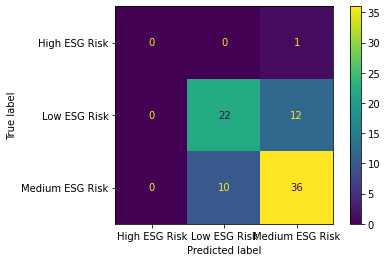

In [ ]:
k_neighbors=KNeighborsClassifier(n_neighbors=KNC.iloc[0][0])
k_neighbors.fit(x_train[list(KNC.iloc[0][1])],y_train)
plot_confusion_matrix(k_neighbors,x_validation[list(KNC.iloc[0][1])],y_validation)
print(classification_report(y_validation,k_neighbors.predict(x_validation[list(KNC.iloc[0][1])])))
print('validation data accuracy score is {}'.format(accuracy_score(y_validation,k_neighbors.predict(x_validation[list(KNC.iloc[0][1])]))))


In [ ]:
print('train data accuracy score is {}'.format(accuracy_score(y_train,k_neighbors.predict(x_train[list(KNC.iloc[0][1])]))))
print('test data accuracy score is {}'.format(accuracy_score(y_test,k_neighbors.predict(x_test[list(KNC.iloc[0][1])]))))

train data accuracy score is 0.6541666666666667
test data accuracy score is 0.5375


In [ ]:
KNC.to_excel('knn_updated.xlsx')

### CSV File Generation for all 7 Models 

In [ ]:
decisionTrees.to_csv('/Users/suzifeng/Desktop/BT4222 Models/decisionTrees.csv')
randomForest.to_csv('/Users/suzifeng/Desktop/BT4222 Models/randomForest.csv')
extraTree.to_csv('/Users/suzifeng/Desktop/BT4222 Models/extraTree.csv')
logisticRegression.to_csv('/Users/suzifeng/Desktop/BT4222 Models/logistic.csv')
SVM_scores.to_csv('/Users/suzifeng/Desktop/BT4222 Models/SVM.csv')
gradientBoost.to_csv('/Users/suzifeng/Desktop/BT4222 Models/gradientBoost.csv')
KNC.to_csv('/Users/suzifeng/Desktop/BT4222 Models/KNC.csv')

### Voting

In [ ]:
decision_tree=DecisionTreeClassifier(criterion=decisionTrees.iloc[0][0][0],max_depth=decisionTrees.iloc[0][0][1])
decision_tree.fit(x_train[list(decisionTrees.iloc[0][1])],y_train)
resultDecisionTree = decision_tree.predict(x_test[list(decisionTrees.iloc[0][1])])

In [ ]:
random_forest=ensemble.RandomForestClassifier(random_state=123)
random_forest.fit(x_train[list(randomForest.iloc[0][0])],y_train)
resultRandomForest = random_forest.predict(x_test[list(randomForest.iloc[0][0])])

In [ ]:
extra_tree=ensemble.ExtraTreesClassifier()
extra_tree.fit(x_train[list(extraTree.iloc[0][0])],y_train)
resultExtraTree = extra_tree.predict(x_test[list(extraTree.iloc[0][0])])

In [ ]:
logit=LogisticRegression()
logit.fit(x_train[list(logisticRegression.iloc[0][0])],y_train)
resultLogit = logit.predict(x_test[list(logisticRegression.iloc[0][0])])

In [ ]:
svm=SVC(kernel=SVM_scores.iloc[0][0],probability=True)
svm.fit(x_train[list(SVM_scores.iloc[0][1])],y_train)
resultSVM = svm.predict(x_test[list(SVM_scores.iloc[0][1])])

In [ ]:
gradient_boost=ensemble.GradientBoostingClassifier()
gradient_boost.fit(x_train[list(gradientBoost.iloc[0][0])],y_train)
resultGradientBoost = gradient_boost.predict(x_test[list(gradientBoost.iloc[0][0])])

In [ ]:
k_neighbors=KNeighborsClassifier(n_neighbors=KNC.iloc[0][0])
k_neighbors.fit(x_train[list(KNC.iloc[0][1])],y_train)
resultKNeigh = k_neighbors.predict(x_test[list(KNC.iloc[0][1])])

In [ ]:
voting = pd.DataFrame()
#voting['Actual Y_Test'] = y_test
voting['Decision Tree'] = resultDecisionTree
#voting['Random Forest'] = resultRandomForest
voting['Extra Tree'] = resultExtraTree
#voting['Logistic Regression'] = resultLogit
#voting['SVM'] = resultSVM
voting['Gradient Boosting'] = resultGradientBoost
#voting['K Neighbors'] = resultKNeigh

def votesRow(idx):
  return voting.iloc[idx].value_counts().index[0]

voting['Voting Result'] = [votesRow(i) for i in range(len(voting))]
voting.head()

,Decision Tree,Extra Tree,Gradient Boosting,Voting Result
0,Medium ESG Risk,Medium ESG Risk,Medium ESG Risk,Medium ESG Risk
1,Medium ESG Risk,Low ESG Risk,Low ESG Risk,Low ESG Risk
2,Low ESG Risk,Medium ESG Risk,Medium ESG Risk,Medium ESG Risk
3,Medium ESG Risk,Medium ESG Risk,Medium ESG Risk,Medium ESG Risk
4,Low ESG Risk,Medium ESG Risk,Medium ESG Risk,Medium ESG Risk


In [ ]:
accuracy_score(y_test,voting['Voting Result'])

0.7

In [ ]:
print(classification_report(y_test,voting['Voting Result']))
confusion_matrix(y_test,voting['Voting Result'])

                 precision    recall  f1-score   support

  High ESG Risk       0.00      0.00      0.00         2
   Low ESG Risk       0.70      0.58      0.63        33
Medium ESG Risk       0.70      0.82      0.76        45

       accuracy                           0.70        80
      macro avg       0.47      0.47      0.46        80
   weighted avg       0.68      0.70      0.69        80



array([[ 0,  0,  2],
       [ 0, 19, 14],
       [ 0,  8, 37]], dtype=int64)